# What if we increase the sim time?

In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    update_mask = t.logical_and(greater_zero_mask, t.logical_and(unequal_mask, sml_eq_two_mask))
    
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [5]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float):
    temperature.requires_grad_()
    for i in tqdm(range(500)):
        #print(f"-------- MCS {i} --------------")
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    std_distance = t.std(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}, standard dev.: {std_distance}")
    loss = (mean_distance - 5)**2 + (std_distance - 5)**2
    print(f"loss: {loss}")
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, loss, mean_distance, std_distance

In [6]:
init_state = t.zeros(1000,128,128, device=device)
init_state[:,64,64] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0].cpu(), return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix).to(device)
print(dist_matrix_t)

tensor([[8192.0000, 8065.0000, 7940.0000,  ..., 7817.0000, 7940.0000,
         8065.0000],
        [8065.0000, 7938.0000, 7813.0000,  ..., 7690.0000, 7813.0000,
         7938.0000],
        [7940.0000, 7813.0000, 7688.0000,  ..., 7565.0000, 7688.0000,
         7813.0000],
        ...,
        [7817.0000, 7690.0000, 7565.0000,  ..., 7442.0000, 7565.0000,
         7690.0000],
        [7940.0000, 7813.0000, 7688.0000,  ..., 7565.0000, 7688.0000,
         7813.0000],
        [8065.0000, 7938.0000, 7813.0000,  ..., 7690.0000, 7813.0000,
         7938.0000]], device='cuda:0', dtype=torch.float64)


In [7]:
temps = t.linspace(1, 35, 35)
target_vol = 0.

losses = []
grads = []
mean_distances = []
std_distances = []
for temp in temps:
    temp.requires_grad_()
    batch = init_state.detach().clone()
    new_temp, grad, loss, mean_distance, std_distance = step(batch, dist_matrix_t, temp, target_vol, eta=1)
    losses.append(loss.detach().cpu().numpy())
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    std_distances.append(std_distance.detach().cpu().numpy())

100%|██████████| 500/500 [05:32<00:00,  1.50it/s]


temperature: 1.0, mean distance: 0.7505000000000001, standard dev.: 1.2631687717851212
loss: 32.02215787816192
gradient: 31.868581771850586


100%|██████████| 500/500 [05:45<00:00,  1.45it/s]


temperature: 2.0, mean distance: 4.782, standard dev.: 5.361457004732071
loss: 0.1781751662698806
gradient: -0.6970993280410767


100%|██████████| 500/500 [05:34<00:00,  1.50it/s]


temperature: 3.0, mean distance: 8.6115, standard dev.: 8.984070976840691
loss: 28.915753798504333
gradient: -46.06425094604492


100%|██████████| 500/500 [04:51<00:00,  1.71it/s]


temperature: 4.0, mean distance: 11.133000000000001, standard dev.: 11.936993040235476
loss: 85.73556144027545
gradient: -81.82876586914062


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


temperature: 5.0, mean distance: 12.935500000000001, standard dev.: 13.433038983521397
loss: 134.08830674759162
gradient: -74.33268737792969


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


temperature: 6.0, mean distance: 14.8295, standard dev.: 15.00722813961886
loss: 196.76368528837955
gradient: -93.5443115234375


100%|██████████| 500/500 [04:46<00:00,  1.74it/s]


temperature: 7.0, mean distance: 15.208, standard dev.: 15.620747217763363
loss: 217.00353546362822
gradient: -53.5648078918457


100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


temperature: 8.0, mean distance: 16.982, standard dev.: 16.754174960175515
loss: 281.72895299441706
gradient: -55.39640808105469


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


temperature: 9.0, mean distance: 17.1055, standard dev.: 17.0666748718967
loss: 292.1477727140633
gradient: -35.05908203125


100%|██████████| 500/500 [04:53<00:00,  1.71it/s]


temperature: 10.0, mean distance: 17.8495, standard dev.: 17.86103627188191
loss: 330.51590423666215
gradient: -36.32829666137695


100%|██████████| 500/500 [15:29<00:00,  1.86s/it]


temperature: 11.0, mean distance: 18.1695, standard dev.: 18.8493983850786
loss: 365.24156587861773
gradient: -35.648468017578125


100%|██████████| 500/500 [16:19<00:00,  1.96s/it]


temperature: 12.0, mean distance: 17.831, standard dev.: 17.820859180059657
loss: 329.0089911149199
gradient: -12.067797660827637


100%|██████████| 500/500 [04:56<00:00,  1.69it/s]


temperature: 13.0, mean distance: 17.8715, standard dev.: 17.828448935460774
loss: 330.24461433972465
gradient: 4.2280168533325195


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


temperature: 14.0, mean distance: 19.177500000000002, standard dev.: 20.35567727464082
loss: 436.79833081292054
gradient: -4.176975250244141


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


temperature: 15.0, mean distance: 18.977, standard dev.: 18.93828476169439
loss: 389.632311098082
gradient: 0.3033508062362671


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


temperature: 16.0, mean distance: 19.872, standard dev.: 20.228081748866696
loss: 453.07085775016697
gradient: 10.175811767578125


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


temperature: 17.0, mean distance: 19.4935, standard dev.: 20.423903733078863
loss: 447.9583486172841
gradient: 19.94847869873047


100%|██████████| 500/500 [04:50<00:00,  1.72it/s]


temperature: 18.0, mean distance: 20.558, standard dev.: 21.15432915139046
loss: 503.0137143314636
gradient: 20.639549255371094


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


temperature: 19.0, mean distance: 19.717, standard dev.: 19.967764603296573
loss: 440.62406621969774
gradient: 11.74197006225586


100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


temperature: 20.0, mean distance: 19.3165, standard dev.: 18.579162059957046
loss: 389.3558145005769
gradient: 6.351846218109131


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


temperature: 21.0, mean distance: 20.6765, standard dev.: 21.21720452368286
loss: 508.75037481295976
gradient: 18.61270523071289


100%|██████████| 500/500 [04:44<00:00,  1.75it/s]


temperature: 22.0, mean distance: 20.76, standard dev.: 21.43229439968059
loss: 518.3978992377741
gradient: 42.35232162475586


100%|██████████| 500/500 [04:53<00:00,  1.70it/s]


temperature: 23.0, mean distance: 20.0705, standard dev.: 19.586843146682245
loss: 439.89596323591076
gradient: 5.112105369567871


100%|██████████| 500/500 [04:46<00:00,  1.74it/s]


temperature: 24.0, mean distance: 20.562, standard dev.: 21.55087228874555
loss: 516.1072175183654
gradient: 13.451412200927734


100%|██████████| 500/500 [04:50<00:00,  1.72it/s]


temperature: 25.0, mean distance: 19.744500000000002, standard dev.: 19.566740327011654
loss: 429.5902040045877
gradient: 10.937827110290527


100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


temperature: 26.0, mean distance: 20.906, standard dev.: 22.141294019615813
loss: 546.8247966669168
gradient: 14.610126495361328


100%|██████████| 500/500 [04:52<00:00,  1.71it/s]


temperature: 27.0, mean distance: 20.192, standard dev.: 21.423610993213927
loss: 500.53186205641737
gradient: 13.833443641662598


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


temperature: 28.0, mean distance: 20.999, standard dev.: 21.0858865903446
loss: 514.7237483974282
gradient: 14.718512535095215


100%|██████████| 500/500 [04:48<00:00,  1.73it/s]


temperature: 29.0, mean distance: 20.686, standard dev.: 20.740433218452807
loss: 493.8118339045726
gradient: 13.811874389648438


100%|██████████| 500/500 [04:38<00:00,  1.79it/s]


temperature: 30.0, mean distance: 21.878, standard dev.: 21.354534230716823
loss: 552.3376739036883
gradient: 13.828001976013184


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


temperature: 31.0, mean distance: 20.4585, standard dev.: 22.1682759968572
loss: 533.7149229542631
gradient: 14.04412841796875


100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


temperature: 32.0, mean distance: 21.565, standard dev.: 20.945799140182007
loss: 528.6677352190293
gradient: 13.651372909545898


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


temperature: 33.0, mean distance: 20.8595, standard dev.: 20.886676682161887
loss: 503.91023625354626
gradient: 13.89340877532959


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


temperature: 34.0, mean distance: 21.279, standard dev.: 21.98055512508223
loss: 553.3450933559564
gradient: 15.077958106994629


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


temperature: 35.0, mean distance: 21.4985, standard dev.: 21.946865674163536
loss: 559.3967584281423
gradient: 12.803863525390625


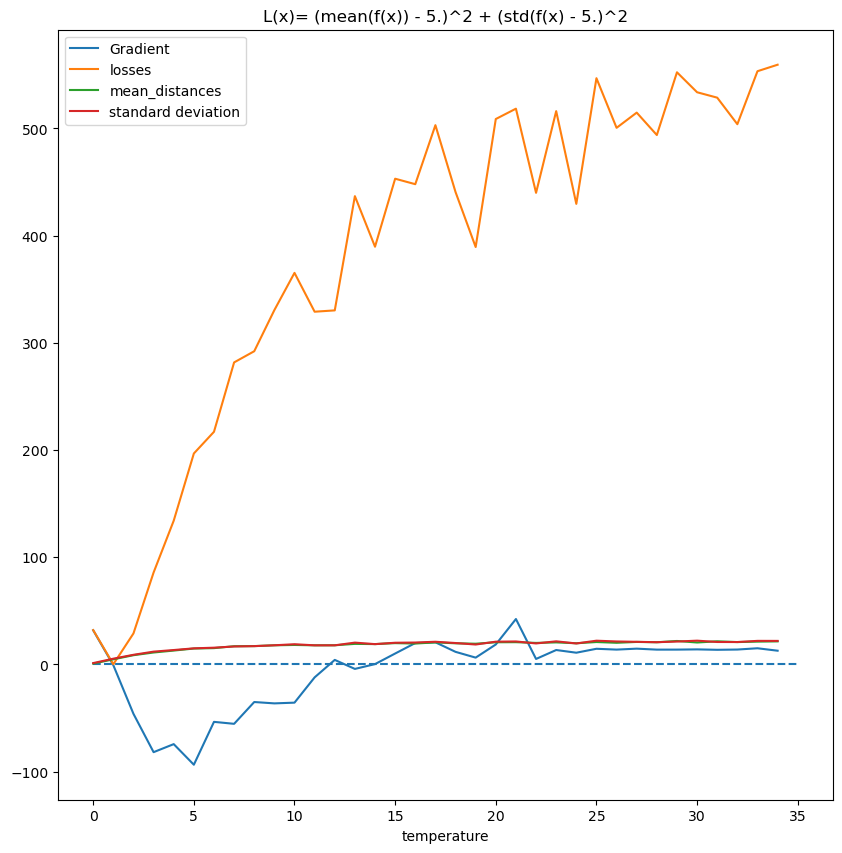

In [8]:
plt.figure(figsize=(10,10))
plt.plot(grads, label="Gradient")
plt.hlines([0.], xmin=0, xmax=35, linestyles="dashed")
plt.plot(np.stack(losses, axis=0), label="losses")
plt.plot(np.stack(mean_distances, axis=0), label="mean_distances")
plt.plot(np.stack(std_distances, axis=0), label="standard deviation")
plt.title("L(x)= (mean(f(x)) - 5.)^2 + (std(f(x) - 5.)^2")
plt.xlabel("temperature")
plt.legend()
